# Autoencoders - part 1
## Understanding autoencoders by comparing them to PCA of data clouds

We compare a very basic Autoencoder to PCA.

In part1 we keep the example simple and focus more on becoming familiar with the Keras syntax for setting up this kind of models and to have a feel for how Neural Network-based Autoencoders differ from linear autoencoders like PCA.

Remember that PCA simply means Eigendecomposition of the covariance of the data. 

    >>> Cov(data) = V*D*V.T
    
In the above, $V$ contains the principal directions (eigenvectors), and $D$ contains the eigenvalues.
    
If you don't keep all the eigenvectors (i.e. only keep a subset of the columns in $V$), we can obtain a low dimensional 'approximation' to the data by simply multiplying the data with $V$:

    >>> data_lowdim = data*V

The approximate data in the 'original dimensions' is:

    >>> data_approx = data*V*V.T
    

An Autoencoder is a generalisation of the above where:

    >>> data_lowdim = Encode( data  )
    >>> data_approx = Decode( data_lowdim )
    
Where Encode(x) and Decode(x) are potentially nonlinear functions of x. 

Of course in PCA, both encoder and decoder are stored in V:  

    >>> Encode == "multiply by V"
    >>> Decode == "multiply by V.T"


In this tutorial we will:

   - Generate 2 dimensional Gaussian data
   - Fit PCA to the data
   - Fit an autoencoder to the data
   - Play a little bit (but not too much) with the setup of the Autoencoder
    

    


In [1]:
# Helper stuff 
# a simple (too simple) PCA class 

import numpy as np

class PCA(object):    
    """Simple PCA class
    
    To instantiate a PCA object:
    
    >>> pca = PCA(data)
    
    To fit the PCA model to the data:
    
    >>> pca.fit()
    
    Encoder:
    
    >>> pca.encode(dim)
    
    Decoder:
    
    >>> pca.decode(data_lowdim)
    
    Predict:
    
    >>> pca.predict(dim)
    
    which is equivalent to:
    
    >>> pca.decode(pca.encode(dim))
    
    """
    def __init__(self, data):
        # Assumes data matrix is NumberSamples X NumberDimensions
        self.data = data.copy()
        self.mean = data.mean(axis=0)
        # Demean the data such that cov(data)=data.T*data
        self.data = data-self.mean
        
    def fit(self):        
        #  Eigvectors of covariance
        Cov = data.T@data
        _,V  = np.linalg.eig(Cov) # ignore eigenvalues
        # Keep Eigenvectors for use later
        self.V = V
        
    def encode(self,data,dim=1):
        # high->low dim version of data
        return data@self.V[:,:dim]
    
    def decode(self,data_lowdim):
        # low->high dim 
        dim = data_lowdim.shape[1]
        return data_lowdim@self.V[:,:dim].T
    
    def predict(self,dim=1):
        # low->high->low dim
        return self.data@self.V[:,:dim]@self.V[:,:dim].T + self.mean


### Generating the data

Below we generate 2D data points from two Gaussian distributions (to add a bit of "nonlinearity")

(-5.070490396084033, 4.514502692244521, -3.542613712523198, 3.8059078302947764)

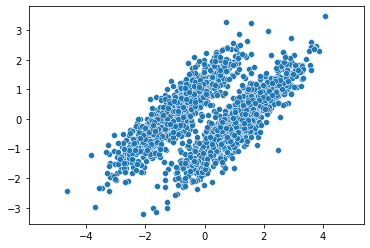

In [2]:

import numpy as np

n     = 1000
cov   = [[1,.9],[.9,1]]
data1 = np.random.multivariate_normal([-1.1,.1],cov,n)
data2 = np.random.multivariate_normal([1.1,-.1],cov,n)
data  = np.concatenate((data1,data2),axis=0)

# Quickly plot the data
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=data[:,0], y=data[:,1])
plt.axis('equal')



### PCA:

Next we do a quick PCA fitting to the data. We keep 1 dimension, and we plot the model prediction. 

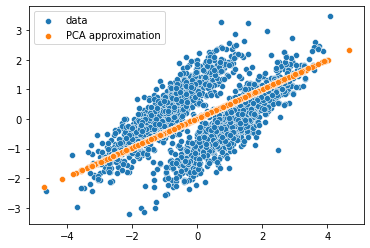

In [4]:
# do a quick PCA fit

pca = PCA(data)
pca.fit()
pca_pred = pca.predict(dim=1)

# the same can be achieved with:
# pca_pred = pca.decode(pca.encode(data,dim=1))


# quick plot 
sns.scatterplot(x=data[:,0], y=data[:,1])
sns.scatterplot(x=pca_pred[:,0], y=pca_pred[:,1])
plt.legend(('data','PCA approximation'))



> What do you think will happen if we used `pca.predict(dim=2)`, i.e. use a 2D encoder? 

## Autoencoder

Now let us define the Autoencoder model. 

We will use a simple feedforward neural network that looks like this:

**Input** -> Layer -> Layer -> **LowDim** -> Layer -> Layer -> **Output**


> Read the below code carefull and make sure you understand what the `create_AE` function does.



In [5]:

from keras.layers import Input, Dense
from keras.models import Model


# creates the autoencoder and outputs the encoder and decoder separately as well
# Note: there are other ways of doing this, I just picked the one that I thought was clearest
def create_AE(input_dim,latent_dim=1):
    
    # Encoder Model
    inputs  = Input(shape=(input_dim,), name='Input')
    x       = Dense(20, activation = 'relu')(inputs)
    x       = Dense(20, activation = 'relu')(x)
    lat     = Dense(latent_dim, activation = 'linear')(x)
    
    encoder = Model(inputs, lat, name='encoder')

    # Decoder model
    lat_input = Input(shape=(latent_dim,))
    x         = Dense(20, activation = 'relu')(lat_input)
    x         = Dense(20, activation = 'relu')(x)
    outputs   = Dense(input_dim, activation = 'linear')(x)
    
    decoder   = Model(lat_input, outputs, name='decoder')
    
    # Autoencoder
    outputs = decoder(encoder(inputs))    
    ae      = Model(inputs, outputs, name='ae')

    return ae,encoder,decoder




Let's create the AE and look at a summary of the parameters

In [14]:
# Create Autoencoder
ae,enc,dec = create_AE(input_dim=data.shape[1],latent_dim=1)
ae.summary()



Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 encoder (Functional)        (None, 1)                 501       
                                                                 
 decoder (Functional)        (None, 2)                 502       
                                                                 
Total params: 1,003
Trainable params: 1,003
Non-trainable params: 0
_________________________________________________________________


### Understanding the model parameters

Does it make sense that it has this many parameters?

Let's see.

 - The input data is 2D. So the first transformation is 2x20 params + 20 biases = 60
 - The second is 20x20+20 = 420
 - The third goes to the low dim space: 20x1+1 = 21
 - In the decoder we have 1->20 so it is 1x20+20 = 40
 - Then 20x20+20 = 420
 - Then finally to the output so 20dim->2dim i.e. 20x2+2 = 42

So in total = 60+420+21+40+420+42=1003 

Before we start training we need a loss function. For example the one defined below is the mean squared error between input and output:


In [15]:
from keras.losses import mse
from keras import backend as K

def recon_loss(inputs,outputs):
    reconstruction_loss = mse(inputs, outputs)    
    return K.mean(reconstruction_loss)   #Note: K is like numpy, but it understands the gradients of the functions you give it


Text(0.5, 0, 'epochs')

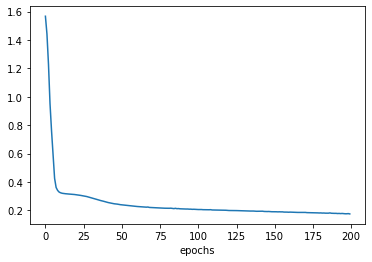

In [16]:
# Training

# define loss function (you can have losses for different parts of the network, here we are only creating a loss for the decoder part)
losses = {'decoder':recon_loss}

# choose optimisation routine
ae.compile(optimizer='adam',loss=losses)

# run the fitting
ae.fit(data,
        {'decoder':data},
        epochs=200,            
        batch_size=128,shuffle=True,verbose=0)

# plot a trace of the loss function over epochs
plt.plot(ae.history.history['loss'])
plt.xlabel('epochs')



Finally, let's look at the prediction of the Autoencoder and compare it to PCA:


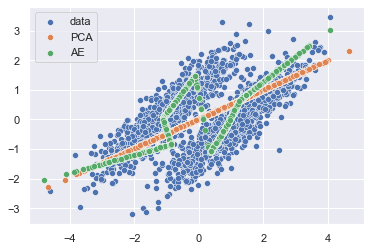

In [17]:
# Look at predictions

out = ae.predict(data)
# equivalently:
# out = dec.predict(enc.predict(data))

import seaborn as sns; sns.set()

sns.scatterplot(x=data[:,0], y=data[:,1])
sns.scatterplot(x=pca_pred[:,0], y=pca_pred[:,1])
sns.scatterplot(x=out[:,0], y=out[:,1])

plt.legend(('data','PCA','AE'))

### Observations:

- It is clear that the AE has more flexibility due to the nonlinearities (but remember PCA only has 2 parameters compared to the 1003 parameters of our Autoencoder!)
- Because we have chosen ReLU, the 1D autoencoder model has kinks in it. You can try with different nonlinearities (like `tanh`) to see how that changes.

In part2 we will apply this to the MNIST data. 


### The End.